# State estimation - further experiments
### With a simpler $2\times 2$ dyadic field

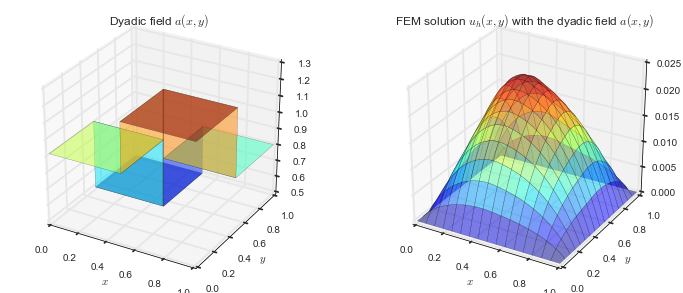

In [2]:
import numpy as np
import importlib
import dyadic_fem as df
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
importlib.reload(df)
%matplotlib inline

# Here we go
fem_div = 5

a = df.make_dyadic_random_field(div=1, a_bar=1.0, c=0.5, seed=1)
fem = df.DyadicFEMSolver(div=fem_div, rand_field=a, f=1.0)
fem.solve()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
a.plot(ax, title='Dyadic field $a(x,y)$')
ax = fig.add_subplot(1, 2, 2, projection='3d')
fem.u.plot(ax, title='FEM solution $u_h(x,y)$ with the dyadic field $a(x,y)$')
plt.show()

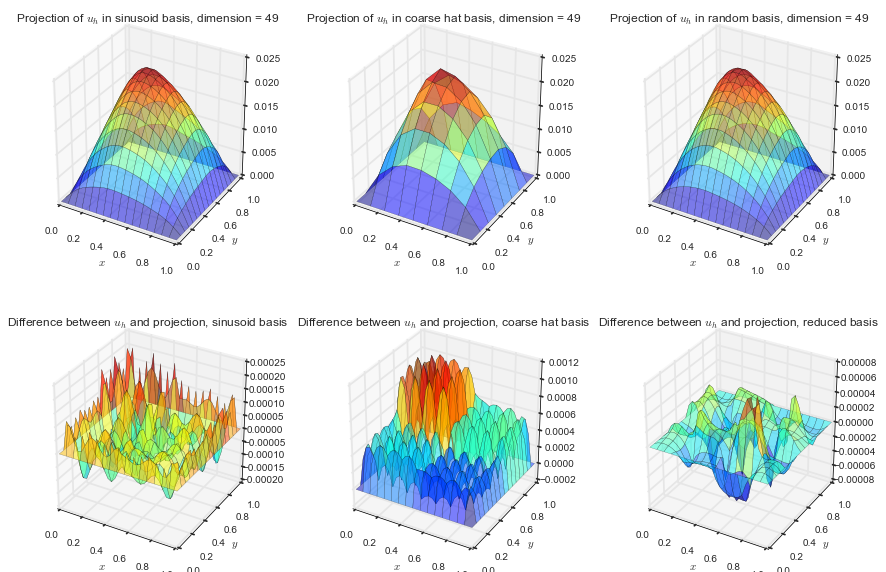

In [2]:
coarse_div = 3
n = (2**coarse_div - 1) * (2**coarse_div - 1)

sin_b = df.make_sin_basis(fem_div, N=2**coarse_div-1, space='H1')
hat_b = df.make_hat_basis(div=coarse_div, space='H1')
np.random.seed(6)
red_b, red_fields = df.make_reduced_basis(n=n, field_div=2, fem_div=fem_div, space='H1')

u_p_sin = sin_b.project(fem.u)
u_p_hat = hat_b.project(fem.u)
u_p_red = red_b.project(fem.u)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 3, 1, projection='3d')
u_p_sin.plot(ax, title='Projection of $u_h$ in sinusoid basis, dimension = {0}'.format(sin_b.n))
ax = fig.add_subplot(2, 3, 2, projection='3d')
u_p_hat.plot(ax, title='Projection of $u_h$ in coarse hat basis, dimension = {0}'.format(hat_b.n))
ax = fig.add_subplot(2, 3, 3, projection='3d')
u_p_red.plot(ax, title='Projection of $u_h$ in random basis, dimension = {0}'.format(red_b.n))
ax = fig.add_subplot(2, 3, 4, projection='3d')
(fem.u - u_p_sin).plot(ax, title='Difference between $u_h$ and projection, sinusoid basis')
ax = fig.add_subplot(2, 3, 5, projection='3d')
(fem.u - u_p_hat).plot(ax, title='Difference between $u_h$ and projection, coarse hat basis')
ax = fig.add_subplot(2, 3, 6, projection='3d')
(fem.u - u_p_red).plot(ax, title='Difference between $u_h$ and projection, reduced basis')

plt.show()

In [3]:
import time
div_levels = range(2,5)
ns = np.zeros(len(div_levels))
sin_err = []
sin_ns = []
hat_err = []
hat_ns = []
red_err = []
red_ns = []

for i in range(2,16):
    sin_b = df.make_sin_basis(fem_div, N=i, space='H1')
    u_p_sin = sin_b.project(fem.u)
    sin_ns.append(sin_b.n)
    sin_err.append((u_p_sin - fem.u).norm(space='H1'))
    
    red_b, red_fields = df.make_reduced_basis(n=i*i, field_div=2, fem_div=fem_div, space='H1')
    u_p_red = red_b.project(fem.u)
    red_ns.append(red_b.n)
    red_err.append((u_p_red - fem.u).norm(space='H1'))

for i, coarse_div in enumerate(div_levels):
    hat_b = df.make_hat_basis(div=coarse_div, space='H1')
    u_p_hat = hat_b.project(fem.u)
    hat_ns.append(hat_b.n)
    hat_err.append((u_p_hat - fem.u).norm(space='H1'))

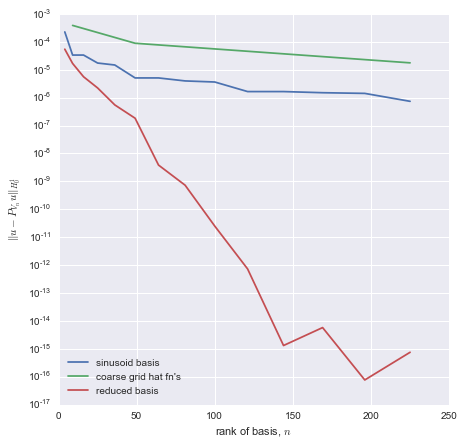

In [4]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")
plt.plot(sin_ns, sin_err, label='sinusoid basis')
plt.plot(hat_ns, hat_err, label='coarse grid hat fn\'s') 
plt.plot(red_ns, red_err, label='reduced basis')
ax.set(xlabel='rank of basis, $n$', ylabel='$\|u - P_{V_n} u\|_{H_0^1}$')
plt.legend(loc=3)
plt.show()

In [5]:
red_err = []
red_ns = []
mis_err = []
mis_ns = []
mis2_err = []
mis2_ns = []

err = np.zeros([4,14])
ns = np.zeros([4,14])

for d in range(4):
    for i in range(2,16):

        red_b, red_fields = df.make_reduced_basis(n=i*i, field_div=d+1, fem_div=fem_div, space='H1')
        u_p_red = red_b.project(fem.u)

        err[d, i-2] = (u_p_red - fem.u).norm(space='H1')
        ns[d, i-2] = red_b.n

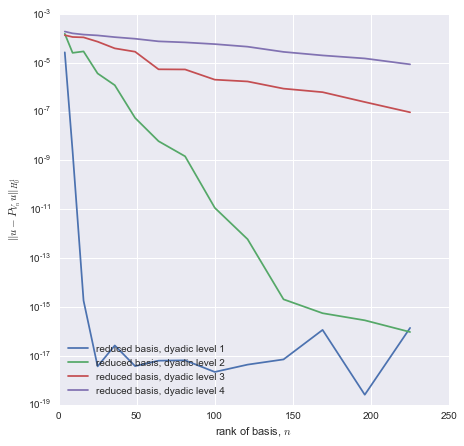

In [6]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")
for d in range(4):
    plt.plot(ns[d,:], err[d,:], label='reduced basis, dyadic level {0}'.format(d+1))
#plt.plot(red_ns, red_err, label='random field basis')
#plt.plot(mis_ns, mis_err, label='random field basis, dyadic level 3')
#plt.plot(mis2_ns, mis2_err, label='random field basis, dyadic level 4')
ax.set(xlabel='rank of basis, $n$', ylabel='$\|u - P_{V_n} u\|_{H_0^1}$')
plt.legend(loc=3)
plt.show()

### Representers of local integration in $H_0^1$
I have constructed the Riesz representers of local dyadic square integration, in the coarse grid subspace, by simply solving for the linear functional against the Grammian

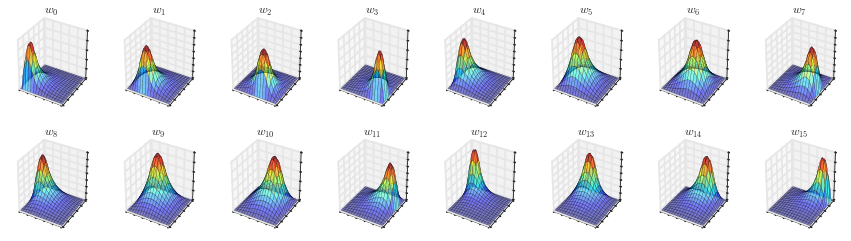

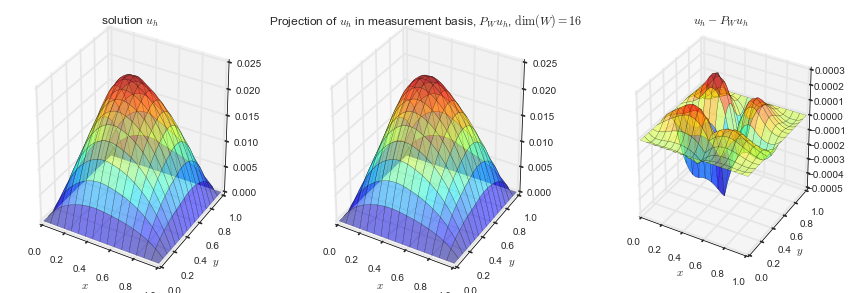

In [7]:
coarse_div = 2
n = (2**coarse_div - 1) * (2**coarse_div - 1)

meas_b = df.make_local_integration_basis(div=fem_div, int_div=coarse_div, space='H1')
u_p_meas = meas_b.project(fem.u)

# There should be 16 fields and 16 solutions.... split in to rows of 8
fig = plt.figure(figsize=(15, 4))
for i, vec in enumerate(meas_b.vecs[:16]):
    ax = fig.add_subplot(2, 8, i+1, projection='3d')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    meas_b.vecs[i].plot(ax, title='$w_{{{0}}}$'.format(i), show_axes_labels=False)
    
plt.show()

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1, projection='3d')
fem.u.plot(ax, title='solution $u_h$')
ax = fig.add_subplot(1, 3, 2, projection='3d')
u_p_meas.plot(ax, title='Projection of $u_h$ in measurement basis, $P_W u_h$, $\dim (W) = {{{0}}}$'.format(meas_b.n))
ax = fig.add_subplot(1, 3, 3, projection='3d')
(fem.u - u_p_meas).plot(ax, title='$u_h - P_W u_h$'.format(meas_b.n))
ax.dist = 11
plt.show()

### Now we try the algorithm with our proper measurement bases

Condition number of G.T * G = 8.209971576363554
Dimensions of W_m = m = 16, dimension of V_n = n = 10
Differences (in H_0^1 norm) between:       
 || u_h - u_star ||	=	4.681726e-09       
 || u_h - P_V u_h ||	=	4.848608e-09       
 || u_h - v_star ||	=	5.617285e-09      
 || u_star - P_V u_h ||	=	1.666380e-09      
 || u_h - P_W u_h ||	=	2.101974e-05


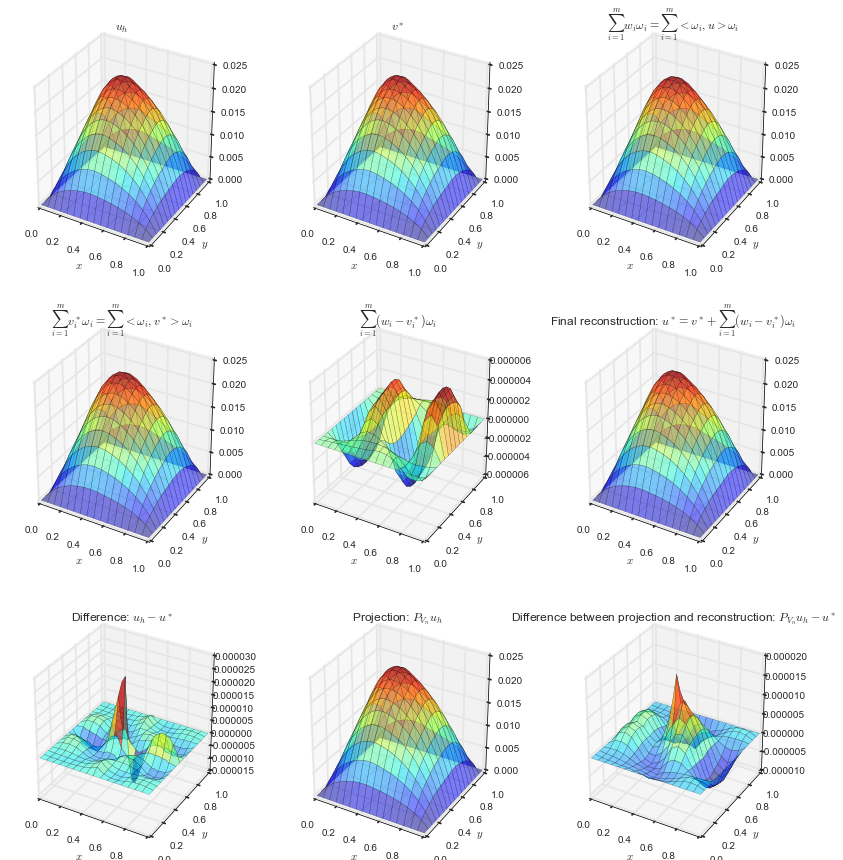

In [8]:
coarse_div = 2
n = (2**coarse_div - 1) * (2**coarse_div - 1)

W_m = df.make_local_integration_basis(div=4, int_div=coarse_div, space='H1')
#u_p_meas = meas_b.project(fem.u)

i = 10
V_n, V_fields = df.make_reduced_basis(n=i, field_div=1, fem_div=fem_div, space='H1')
u_p_v = V_n.project(fem.u)
V_n = V_n.orthonormalise()
# This is the measurement vector
W_ortho = W_m.orthonormalise()
w = W_ortho.dot(fem.u)
u_p_w = W_ortho.project(fem.u)

u_star, v_star, w_recon, v_proj, cond = df.optimal_reconstruction(W_ortho, V_n, w, disp_cond=True)

print('Dimensions of W_m = m = {0}, dimension of V_n = n = {1}'.format(W_m.n, V_n.n))
print('Differences (in H_0^1 norm) between: \
      \n || u_h - u_star ||\t=\t{0:e} \
      \n || u_h - P_V u_h ||\t=\t{1:e} \
      \n || u_h - v_star ||\t=\t{2:e}\
      \n || u_star - P_V u_h ||\t=\t{3:e}\
      \n || u_h - P_W u_h ||\t=\t{4:e}'.format((fem.u-u_star).norm(space='H1'), 
      (fem.u-u_p_v).norm(space='H1'), (fem.u-v_star).norm(space='H1'),(u_star-u_p_v).norm(space='H1')
                                                 ,(fem.u-u_p_w).norm(space='H1')))

%matplotlib inline
fig = plt.figure(figsize=(14, 15))
ax = fig.add_subplot(3, 3, 1, projection='3d')
fem.u.plot(ax, title='$u_h$')
ax = fig.add_subplot(3, 3, 2, projection='3d')
v_star.plot(ax, title='$v^*$')
ax = fig.add_subplot(3, 3, 3, projection='3d')
w_recon.plot(ax, title='$\sum_{i=1}^m w_i \omega_i = \sum_{i=1}^m < \omega_i, u > \omega_i$')
ax = fig.add_subplot(3, 3, 4, projection='3d')
v_proj.plot(ax, title='$\sum_{i=1}^m v^*_i \omega_i = \sum_{i=1}^m < \omega_i, v^* > \omega_i$')
ax = fig.add_subplot(3, 3, 5, projection='3d')
(w_recon - v_proj).plot(ax, title='$\sum_{i=1}^m(w_i - v_i^*)\omega_i$')
ax = fig.add_subplot(3, 3, 6, projection='3d')
u_star.plot(ax, title='Final reconstruction: $u^* = v^* + \sum_{i=1}^m(w_i - v_i^*)\omega_i$')
ax = fig.add_subplot(3, 3, 7, projection='3d')
(fem.u - u_star).plot(ax, title='Difference: $u_h - u^*$')
ax = fig.add_subplot(3, 3, 8, projection='3d')
u_p_v.plot(ax, title='Projection: $P_{V_n} u_h$')
ax = fig.add_subplot(3, 3, 9, projection='3d')
(u_p_v - u_star).plot(ax, title='Difference between projection and reconstruction: $P_{V_n} u_h - u^*$')

### Now we explore varying the rank of our measurement and reconstruction basis, to see error levels
We do this with different dyadic division levels for the random field - this means the projection in the reconstruction basis $V_n$ has varying degrees of convergence, i.e.
$$\| u_h - P_{V_n} u_h \|_{H_0^1}$$
converges slower as $n\to \infty$ when $a(x)$ is generated on finer dyadic grids. However, we always have the constraint that $n<m$ where $m$ is the rank of the measurement basis $W_m$. Thus we have an interesting set of phenomena to observe as we vary $m$ and $n$.

We consider the solution $u_h(x, a(y))$ where $a(y)$ is a field of dyadic level 2, i.e. $y\in \mathbb{R}^{2^2 \times 2^2} = \mathbb{R}^{16}$, and also of dyadic level 3, i.e. $y\in \mathbb{R}^{2^3 \times 2^3} = \mathbb{R}^{64}$

In [1]:
fem_div = 7

a_16 = df.make_dyadic_random_field(div=2, a_bar=1.0, c=0.5, seed=1)
fem_16 = df.DyadicFEMSolver(div=fem_div, rand_field=a_16, f=1.0)
fem_16.solve()

a_64 = df.make_dyadic_random_field(div=3, a_bar=1.0, c=0.5, seed=1)
fem_64 = df.DyadicFEMSolver(div=fem_div, rand_field=a_64, f=1.0)
fem_64.solve()


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(2, 2, 1, projection='3d')
a_16.plot(ax, title='Random field $a$ on dyadic level 2 grid')
ax = fig.add_subplot(2, 2, 2, projection='3d')
fem_16.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_16}$)')
ax = fig.add_subplot(2, 2, 3, projection='3d')
a_64.plot(ax, title='Dyadic field $a$ on dyadic level 3 grid')
ax = fig.add_subplot(2, 2, 4, projection='3d')
fem_64.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_64}$)')
plt.show()

NameError: name 'df' is not defined

Now we see that projection in the basis $V_n$ does not converge so quickly...

In [10]:
div_levels = range(2,5)
ns = np.zeros(len(div_levels))
bas_levels = range(2,16)

err = np.zeros([len(bas_levels), 2, 2])
ns = np.zeros([len(bas_levels), 2])

hat_err = np.zeros([len(div_levels), 2])
hat_ns = np.zeros([len(div_levels)])

for i, n in enumerate(bas_levels):
    sin_b = df.make_sin_basis(fem_div, N=n, space='H1')
    ns[i, 0] = sin_b.n
    u_p_sin = sin_b.project(fem_16.u)
    err[i, 0, 0] = (u_p_sin - fem_16.u).norm(space='H1')
    u_p_sin = sin_b.project(fem_64.u)
    err[i, 0, 1] = (u_p_sin - fem_64.u).norm(space='H1')
    
    red_b, red_fields = df.make_reduced_basis(n=n*n, field_div=2, fem_div=fem_div, space='H1')
    ns[i, 1] = red_b.n
    u_p_red = red_b.project(fem_16.u)
    err[i, 1, 0] = (u_p_red - fem_16.u).norm(space='H1')
    red_b, red_fields = df.make_reduced_basis(n=n*n, field_div=3, fem_div=fem_div, space='H1')
    u_p_red = red_b.project(fem_64.u)
    err[i, 1, 1] = (u_p_red - fem_64.u).norm(space='H1')

for i, coarse_div in enumerate(div_levels):
    hat_b = df.make_hat_basis(div=coarse_div, space='H1')
    hat_ns[i] = hat_b.n
    u_p_hat = hat_b.project(fem_16.u)
    hat_err[i, 0] = (u_p_hat - fem_16.u).norm(space='H1')
    u_p_hat = hat_b.project(fem_64.u)
    hat_err[i, 1] = (u_p_hat - fem_64.u).norm(space='H1')

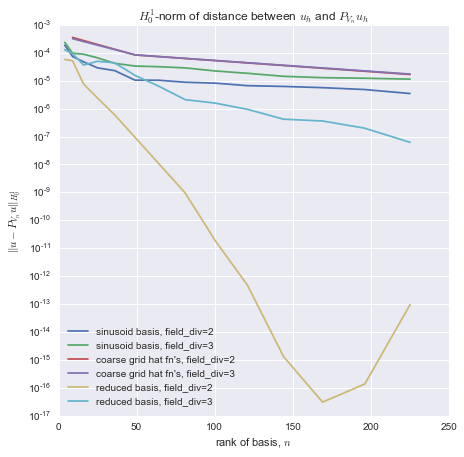

In [11]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")
plt.plot(ns[:,0], err[:,0,0], label='sinusoid basis, field_div=2')
plt.plot(ns[:,0], err[:,0,1], label='sinusoid basis, field_div=3')
plt.plot(hat_ns, hat_err[:,0], label='coarse grid hat fn\'s, field_div=2') 
plt.plot(hat_ns, hat_err[:,1], label='coarse grid hat fn\'s, field_div=3') 
plt.plot(ns[:,1], err[:,1,0], label='reduced basis, field_div=2')
plt.plot(ns[:,1], err[:,1,1], label='reduced basis, field_div=3')
ax.set(title='$H_0^1$-norm of distance between $u_h$ and $P_{V_n} u_h$', xlabel='rank of basis, $n$', ylabel='$\|u - P_{V_n} u\|_{H_0^1}$')
plt.legend(loc=3)
plt.show()

### We consider the reduced basis $V_n$ and the randomly placed local measurements $W_m$ with varying $n$ and $m$
Note that the $W_m$ and $V_n$ are not embedded, that is a new random basis is generated for every value of $m$ and $n$. We will look at embedding later.

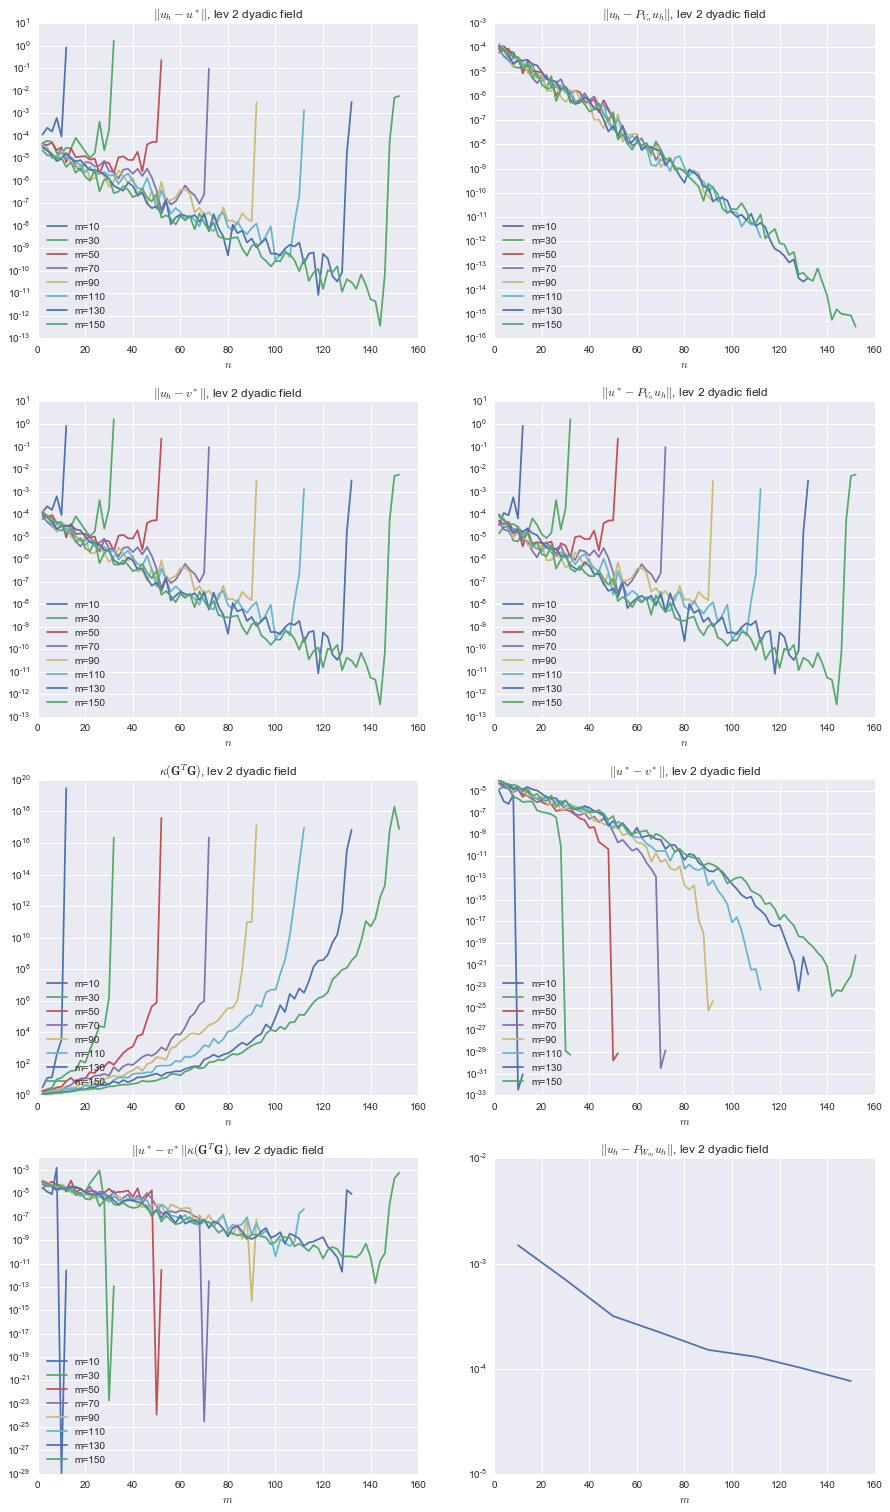

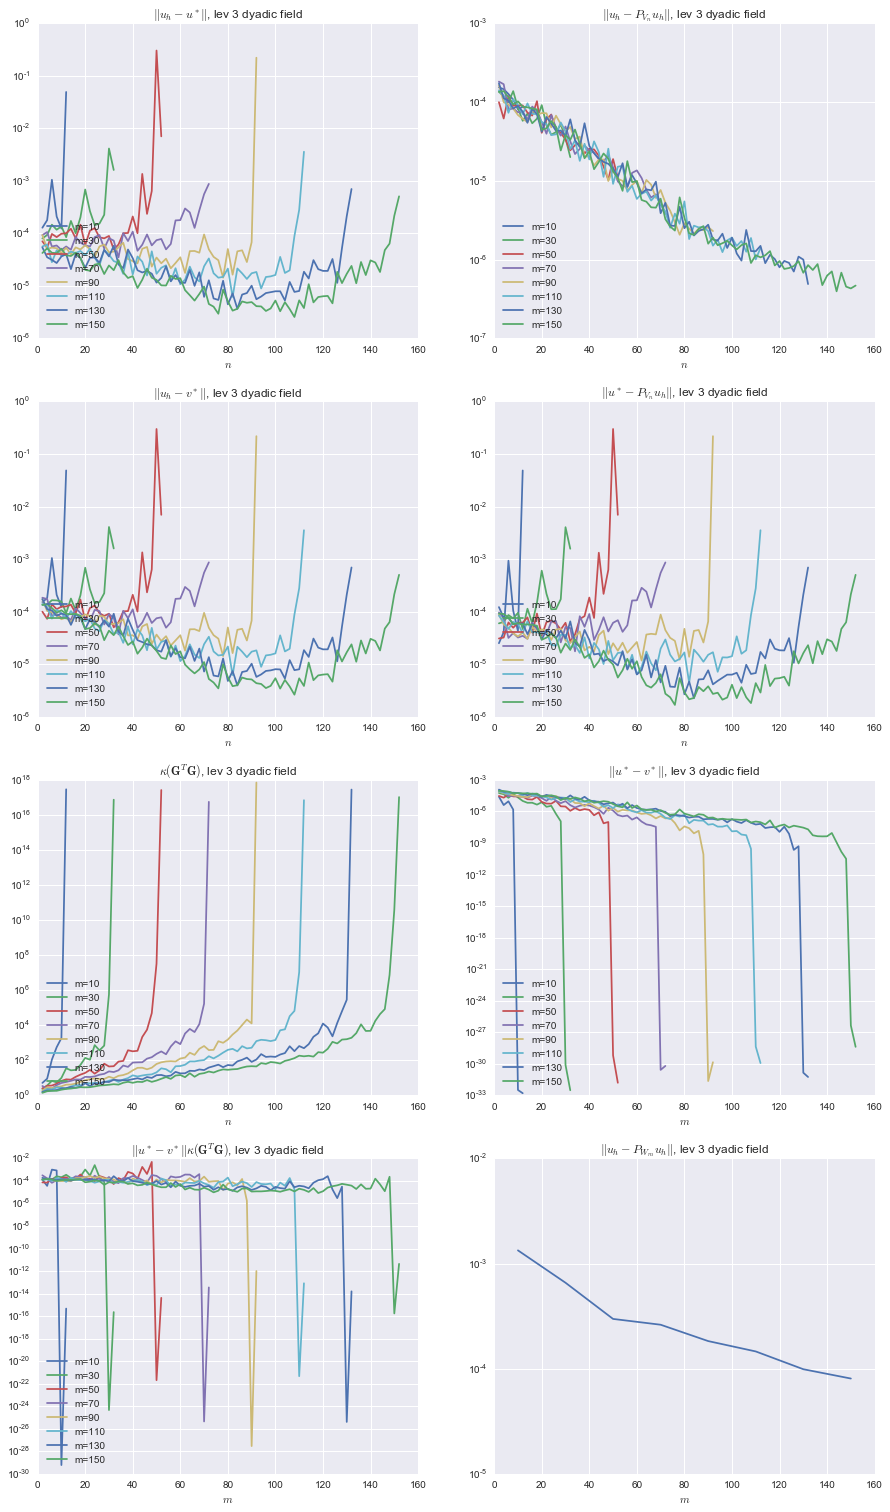

In [12]:
local_width = 2**(fem_div - 4)

fig_16 = plt.figure(figsize=(15, 26))
axs_16 = []
axs_16.append(fig_16.add_subplot(4, 2, 1, title='$\| u_h - u^* \|$, lev 2 dyadic field'))
axs_16[-1].set(yscale="log", xlabel='$n$')
axs_16.append(fig_16.add_subplot(4, 2, 2, title='$\| u_h - P_{V_n} u_h \|$, lev 2 dyadic field'))
axs_16[-1].set(yscale="log", xlabel='$n$')
axs_16.append(fig_16.add_subplot(4, 2, 3, title='$\| u_h - v^* \|$, lev 2 dyadic field'))
axs_16[-1].set(yscale="log", xlabel='$n$')
axs_16.append(fig_16.add_subplot(4, 2, 4, title='$\| u^* - P_{V_n} u_h \|$, lev 2 dyadic field'))
axs_16[-1].set(yscale="log", xlabel='$n$')
axs_16.append(fig_16.add_subplot(4, 2, 5, title='$\kappa (\mathbf{G}^T \mathbf{G})$, lev 2 dyadic field'))
axs_16[-1].set(yscale="log", xlabel='$n$')
axs_16.append(fig_16.add_subplot(4, 2, 6, title='$\| u^* - v^* \|$, lev 2 dyadic field'))
axs_16[-1].set(yscale="log", xlabel='$m$')
axs_16.append(fig_16.add_subplot(4, 2, 7, title='$\| u^* - v^* \| \kappa (\mathbf{G}^T \mathbf{G})$, lev 2 dyadic field'))
axs_16[-1].set(yscale="log", xlabel='$m$')
axs_16.append(fig_16.add_subplot(4, 2, 8, title='$\| u_h - P_{W_m} u_h \|$, lev 2 dyadic field'))
axs_16[-1].set(yscale="log", xlabel='$m$')

fig_64 = plt.figure(figsize=(15, 26))
axs_64 = []
axs_64.append(fig_64.add_subplot(4, 2, 1, title='$\| u_h - u^* \|$, lev 3 dyadic field'))
axs_64[-1].set(yscale="log", xlabel='$n$')
axs_64.append(fig_64.add_subplot(4, 2, 2, title='$\| u_h - P_{V_n} u_h \|$, lev 3 dyadic field'))
axs_64[-1].set(yscale="log", xlabel='$n$')
axs_64.append(fig_64.add_subplot(4, 2, 3, title='$\| u_h - v^* \|$, lev 3 dyadic field'))
axs_64[-1].set(yscale="log", xlabel='$n$')
axs_64.append(fig_64.add_subplot(4, 2, 4, title='$\| u^* - P_{V_n} u_h \|$, lev 3 dyadic field'))
axs_64[-1].set(yscale="log", xlabel='$n$')
axs_64.append(fig_64.add_subplot(4, 2, 5, title='$\kappa (\mathbf{G}^T \mathbf{G})$, lev 3 dyadic field'))
axs_64[-1].set(yscale="log", xlabel='$n$')
axs_64.append(fig_64.add_subplot(4, 2, 6, title='$\| u^* - v^* \|$, lev 3 dyadic field'))
axs_64[-1].set(yscale="log", xlabel='$m$')
axs_64.append(fig_64.add_subplot(4, 2, 7, title='$\| u^* - v^* \| \kappa (\mathbf{G}^T \mathbf{G})$, lev 3 dyadic field'))
axs_64[-1].set(yscale="log", xlabel='$m$')
axs_64.append(fig_64.add_subplot(4, 2, 8, title='$\| u_h - P_{W_m} u_h \|$, lev 3 dyadic field'))
axs_64[-1].set(yscale="log", xlabel='$m$')

ms = range(10,151,20)
#stats_16 = np.zeros([6, len(ms), ms[-1]/2])
#stats_64 = np.zeros([6, len(ms), ms[-1]/2])
w_dist_16 = np.zeros(len(ms))
w_dist_64 = np.zeros(len(ms))

for j, m in enumerate(ms):
    
    W_m = df.make_random_local_integration_basis(m=m, div=fem_div, width=local_width, space='H1')
    W_ortho = W_m.orthonormalise()
    
    # This is the measurement vector
    w_16 = W_ortho.dot(fem_16.u)
    u_p_w_16 = W_ortho.project(fem_16.u)
    w_64 = W_ortho.dot(fem_64.u)
    u_p_w_64 = W_ortho.project(fem_64.u)

    w_dist_16[j] = (fem_16.u-u_p_w_16).norm(space='H1')
    w_dist_64[j] = (fem_64.u-u_p_w_64).norm(space='H1')
    
    ns = range(2, m+3, 2)
    stats_16 = np.zeros([8, len(ns)])
    stats_64 = np.zeros([8, len(ns)])
    
    for i, n in enumerate(ns):
        
        V_n_16, V_fields = df.make_reduced_basis(n=n, field_div=2, fem_div=fem_div, space='H1')
        V_n_64, V_fields = df.make_reduced_basis(n=n, field_div=3, fem_div=fem_div, space='H1')
        V_n_16 = V_n_16.orthonormalise()
        V_n_64 = V_n_64.orthonormalise()
        
        u_p_v_16 = V_n_16.project(fem_16.u)
        u_p_v_64 = V_n_64.project(fem_64.u)

        u_star, v_star, w_recon, v_proj, cond = df.optimal_reconstruction(W_ortho, V_n_16, w_16, disp_cond=False)

        stats_16[0, i] = (fem_16.u-u_star).norm(space='H1')
        stats_16[1, i] = (fem_16.u-u_p_v_16).norm(space='H1')
        stats_16[2, i] = (fem_16.u-v_star).norm(space='H1')
        stats_16[3, i] = (u_star-u_p_v_16).norm(space='H1')
        stats_16[4, i] = cond
        stats_16[5, i] = (u_star - v_star).norm(space='H1')
        stats_16[6, i] = cond * (u_star - v_star).norm(space='H1')

        u_star, v_star, w_recon, v_proj, cond = df.optimal_reconstruction(W_ortho, V_n_64, w_64, disp_cond=False)

        stats_64[0, i] = (fem_64.u-u_star).norm(space='H1')
        stats_64[1, i] = (fem_64.u-u_p_v_64).norm(space='H1')
        stats_64[2, i] = (fem_64.u-v_star).norm(space='H1')
        stats_64[3, i] = (u_star-u_p_v_64).norm(space='H1')
        #stats_64[4, i] = (fem_64.u-u_p_w_64).norm(space='H1')
        stats_64[4, i] = cond
        stats_64[5, i] = (u_star - v_star).norm(space='H1')
        stats_64[6, i] = cond * (u_star - v_star).norm(space='H1')
    
    for k in range(7):
        #fig_16.sca(axs_16[k])
        axs_16[k].plot(ns, stats_16[k,:], label='m={0}'.format(m))
        axs_16[k].legend(loc=3)
        #plt.sca(axs_64[j])
        #fig_64.sca(axs_64[j])
        axs_64[k].plot(ns, stats_64[k,:], label='m={0}'.format(m))
        axs_64[k].legend(loc=3)

axs_16[7].plot(ms, w_dist_16)
axs_64[7].plot(ms, w_dist_64)
#plt.legend(loc=3)
plt.show()


### I noticed there is a point with $n$ after which the reduced basis $V_n$ becomes non-positive definite
which evidently occurs because for the small dyadic-division random fields, we get quite close to linear dependency with enough random fields

In [13]:
n = 10
while True:
    try:
        V_n_16, V_fields = df.make_reduced_basis(n=n, field_div=1, fem_div=fem_div, space='H1')
        V_n_16.orthonormalise()
    except:
        print("Dyadic level 1: V_n linearly dependent at approx n={0}".format(n))
        break
    n += 1

n = 10
while True:
    try:
        V_n_16, V_fields = df.make_reduced_basis(n=n, field_div=2, fem_div=fem_div, space='H1')
        V_n_16.orthonormalise()
    except:
        print("Dyadic level 2: V_n linearly dependent at approx n={0}".format(n))
        break
    n += 2   

n = 10
while True:
    try:
        V_n_64, V_fields = df.make_reduced_basis(n=n, field_div=3, fem_div=fem_div, space='H1')
        V_n_64.orthonormalise()
    except:
        print("Dyadic level 3: V_n linearly dependent at approx n={0}".format(n))
        break
    n += 10
    

Dyadic level 1: V_n linearly dependent at approx n=17
Dyadic level 2: V_n linearly dependent at approx n=158
Dyadic level 3: V_n linearly dependent at approx n=460


### The same experiment as above, with varying $n$ and $m$, but with the sinusoidal basis for $V_n$

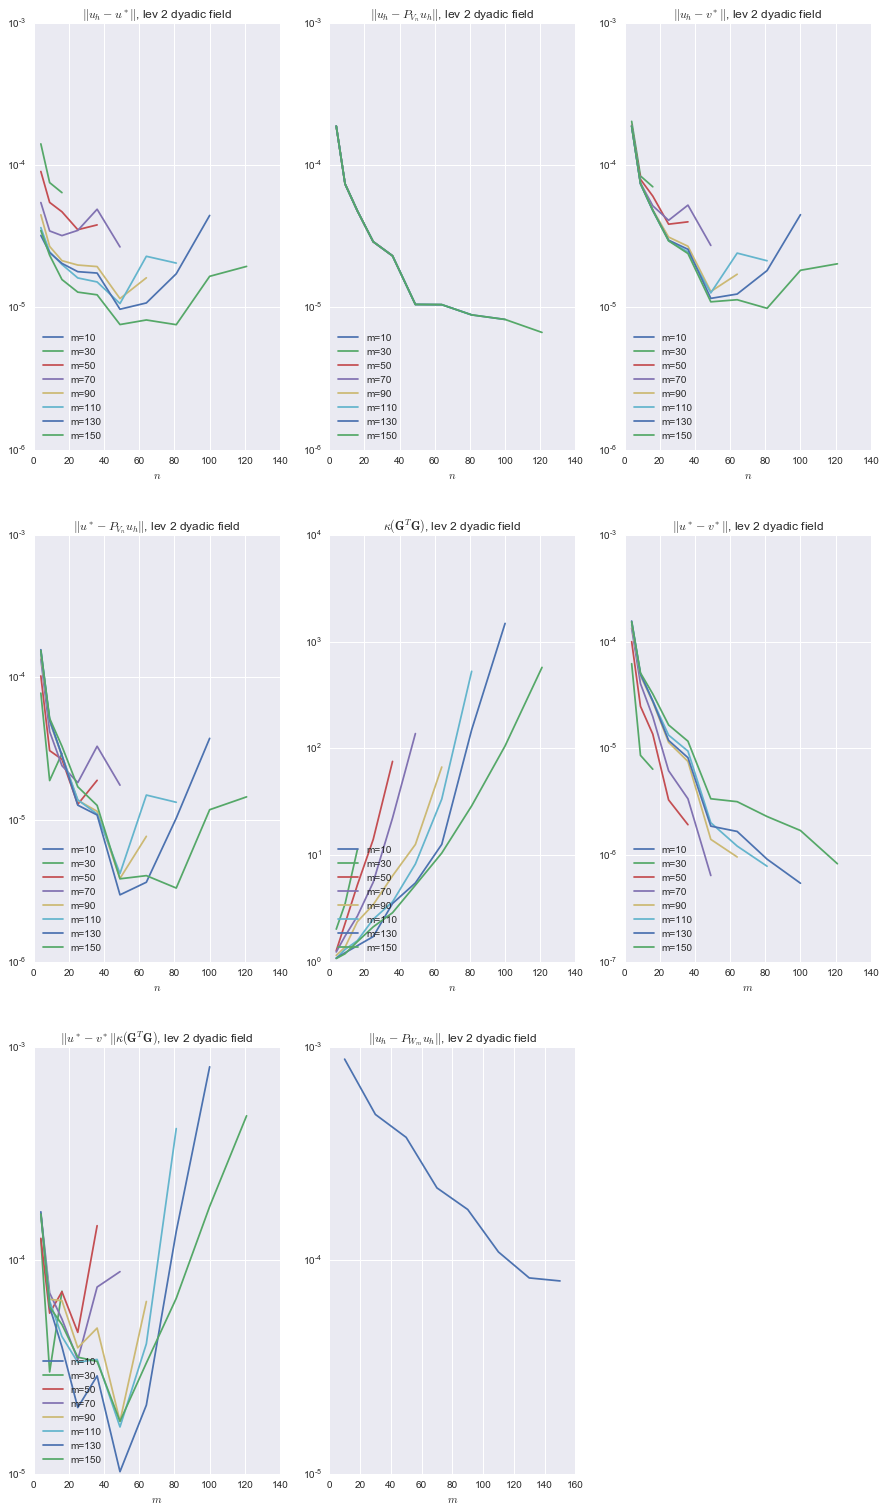

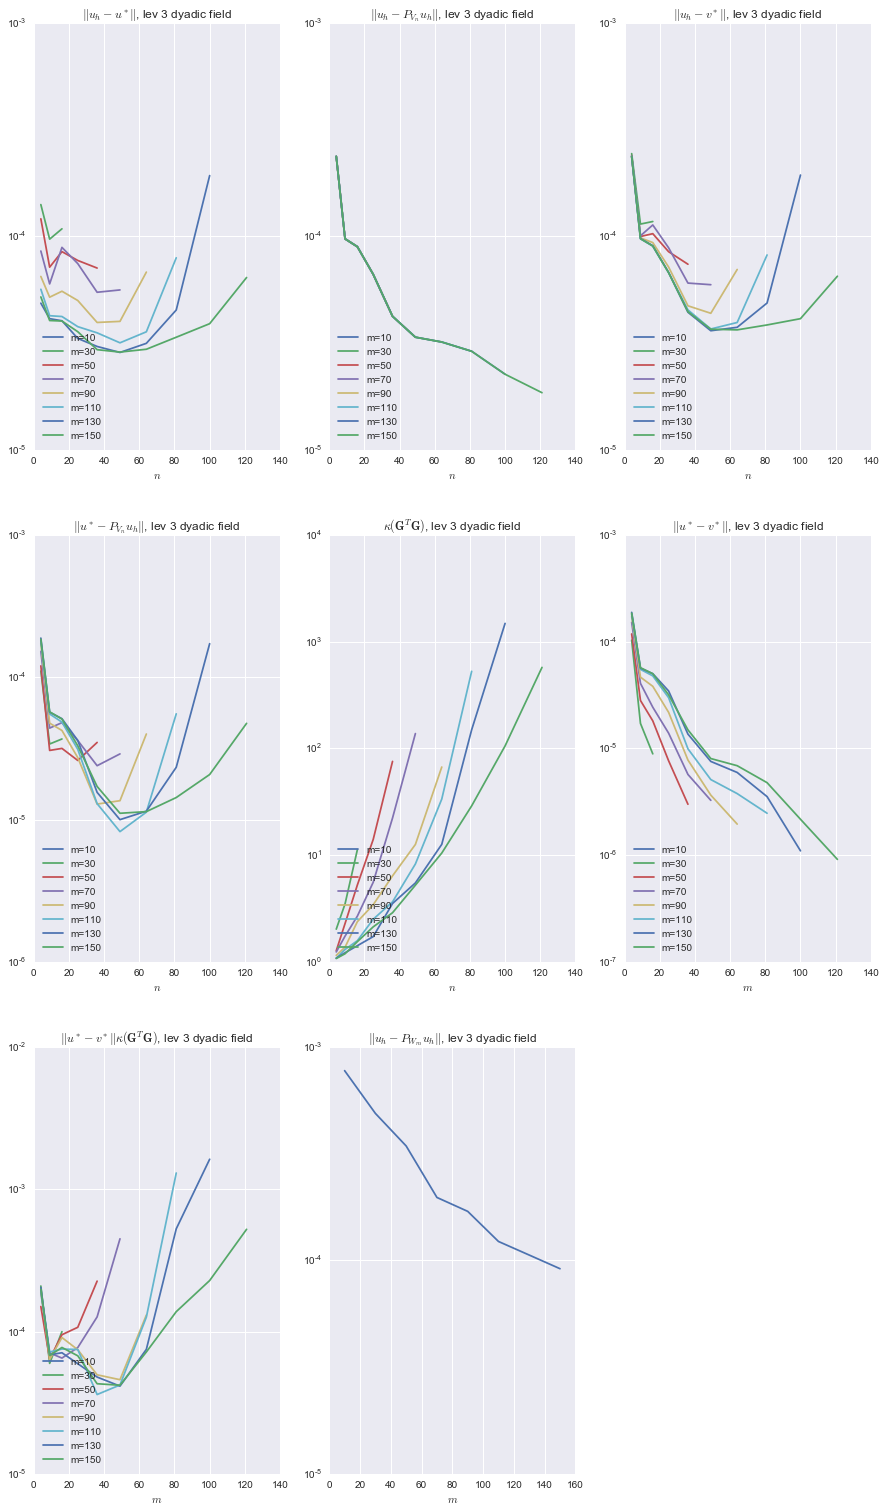

In [14]:
import math

local_width = 2**(fem_div - 4)

fig_16 = plt.figure(figsize=(15, 26))
axs_16 = []
axs_16.append(fig_16.add_subplot(3, 3, 1, title='$\| u_h - u^* \|$, lev 2 dyadic field'))
axs_16[-1].set(yscale="log", xlabel='$n$')
axs_16.append(fig_16.add_subplot(3, 3, 2, title='$\| u_h - P_{V_n} u_h \|$, lev 2 dyadic field'))
axs_16[-1].set(yscale="log", xlabel='$n$')
axs_16.append(fig_16.add_subplot(3, 3, 3, title='$\| u_h - v^* \|$, lev 2 dyadic field'))
axs_16[-1].set(yscale="log", xlabel='$n$')
axs_16.append(fig_16.add_subplot(3, 3, 4, title='$\| u^* - P_{V_n} u_h \|$, lev 2 dyadic field'))
axs_16[-1].set(yscale="log", xlabel='$n$')
axs_16.append(fig_16.add_subplot(3, 3, 5, title='$\kappa (\mathbf{G}^T \mathbf{G})$, lev 2 dyadic field'))
axs_16[-1].set(yscale="log", xlabel='$n$')
axs_16.append(fig_16.add_subplot(3, 3, 6, title='$\| u^* - v^* \|$, lev 2 dyadic field'))
axs_16[-1].set(yscale="log", xlabel='$m$')
axs_16.append(fig_16.add_subplot(3, 3, 7, title='$\| u^* - v^* \| \kappa (\mathbf{G}^T \mathbf{G})$, lev 2 dyadic field'))
axs_16[-1].set(yscale="log", xlabel='$m$')
axs_16.append(fig_16.add_subplot(3, 3, 8, title='$\| u_h - P_{W_m} u_h \|$, lev 2 dyadic field'))
axs_16[-1].set(yscale="log", xlabel='$m$')

fig_64 = plt.figure(figsize=(15, 26))
axs_64 = []
axs_64.append(fig_64.add_subplot(3, 3, 1, title='$\| u_h - u^* \|$, lev 3 dyadic field'))
axs_64[-1].set(yscale="log", xlabel='$n$')
axs_64.append(fig_64.add_subplot(3, 3, 2, title='$\| u_h - P_{V_n} u_h \|$, lev 3 dyadic field'))
axs_64[-1].set(yscale="log", xlabel='$n$')
axs_64.append(fig_64.add_subplot(3, 3, 3, title='$\| u_h - v^* \|$, lev 3 dyadic field'))
axs_64[-1].set(yscale="log", xlabel='$n$')
axs_64.append(fig_64.add_subplot(3, 3, 4, title='$\| u^* - P_{V_n} u_h \|$, lev 3 dyadic field'))
axs_64[-1].set(yscale="log", xlabel='$n$')
axs_64.append(fig_64.add_subplot(3, 3, 5, title='$\kappa (\mathbf{G}^T \mathbf{G})$, lev 3 dyadic field'))
axs_64[-1].set(yscale="log", xlabel='$n$')
axs_64.append(fig_64.add_subplot(3, 3, 6, title='$\| u^* - v^* \|$, lev 3 dyadic field'))
axs_64[-1].set(yscale="log", xlabel='$m$')
axs_64.append(fig_64.add_subplot(3, 3, 7, title='$\| u^* - v^* \| \kappa (\mathbf{G}^T \mathbf{G})$, lev 3 dyadic field'))
axs_64[-1].set(yscale="log", xlabel='$m$')
axs_64.append(fig_64.add_subplot(3, 3, 8, title='$\| u_h - P_{W_m} u_h \|$, lev 3 dyadic field'))
axs_64[-1].set(yscale="log", xlabel='$m$')

ms = range(10,151,20)
#stats_16 = np.zeros([6, len(ms), ms[-1]/2])
#stats_64 = np.zeros([6, len(ms), ms[-1]/2])
w_dist_16 = np.zeros(len(ms))
w_dist_64 = np.zeros(len(ms))

for j, m in enumerate(ms):
    
    W_m = df.make_random_local_integration_basis(m=m, div=fem_div, width=local_width, space='H1')
    W_ortho = W_m.orthonormalise()
    
    # This is the measurement vector
    w_16 = W_ortho.dot(fem_16.u)
    u_p_w_16 = W_ortho.project(fem_16.u)
    w_64 = W_ortho.dot(fem_64.u)
    u_p_w_64 = W_ortho.project(fem_64.u)

    w_dist_16[j] = (fem_16.u-u_p_w_16).norm(space='H1')
    w_dist_64[j] = (fem_64.u-u_p_w_64).norm(space='H1')
    
    # the total 
    ns = np.array(range(2, math.floor(math.sqrt(m))))
    stats_16 = np.zeros([8, len(ns)])
    stats_64 = np.zeros([8, len(ns)])
    
    for i, n in enumerate(ns):
        
        V_n_16 = df.make_sin_basis(div=fem_div, N=n, space='H1')
        V_n_64 = df.make_sin_basis(div=fem_div, N=n, space='H1')
        V_n_16 = V_n_16.orthonormalise()
        V_n_64 = V_n_64.orthonormalise()
        
        u_p_v_16 = V_n_16.project(fem_16.u)
        u_p_v_64 = V_n_64.project(fem_64.u)

        u_star, v_star, w_recon, v_proj, cond = df.optimal_reconstruction(W_ortho, V_n_16, w_16, disp_cond=False)

        stats_16[0, i] = (fem_16.u-u_star).norm(space='H1')
        stats_16[1, i] = (fem_16.u-u_p_v_16).norm(space='H1')
        stats_16[2, i] = (fem_16.u-v_star).norm(space='H1')
        stats_16[3, i] = (u_star-u_p_v_16).norm(space='H1')
        stats_16[4, i] = cond
        stats_16[5, i] = (u_star - v_star).norm(space='H1')
        stats_16[6, i] = cond * (u_star - v_star).norm(space='H1')

        u_star, v_star, w_recon, v_proj, cond = df.optimal_reconstruction(W_ortho, V_n_64, w_64, disp_cond=False)

        stats_64[0, i] = (fem_64.u-u_star).norm(space='H1')
        stats_64[1, i] = (fem_64.u-u_p_v_64).norm(space='H1')
        stats_64[2, i] = (fem_64.u-v_star).norm(space='H1')
        stats_64[3, i] = (u_star-u_p_v_64).norm(space='H1')
        #stats_64[4, i] = (fem_64.u-u_p_w_64).norm(space='H1')
        stats_64[4, i] = cond
        stats_64[5, i] = (u_star - v_star).norm(space='H1')
        stats_64[6, i] = cond * (u_star - v_star).norm(space='H1')
    
    for k in range(7):
        #fig_16.sca(axs_16[k])
        axs_16[k].plot(ns*ns, stats_16[k,:], label='m={0}'.format(m))
        axs_16[k].legend(loc=3)
        #plt.sca(axs_64[j])
        #fig_64.sca(axs_64[j])
        axs_64[k].plot(ns*ns, stats_64[k,:], label='m={0}'.format(m))
        axs_64[k].legend(loc=3)

axs_16[7].plot(ms, w_dist_16)
axs_64[7].plot(ms, w_dist_64)
#plt.legend(loc=3)
plt.show()


## Calculating $\beta(V_n, W_m)$

We have defined $\beta(V_n, W_m) = \inf_{v\in V_n} \frac{\| P_{W_m} v \|}{\| v \|} = \inf_{\| v \|_{V_n}=1} \| P_{W_m} v \|$

Now assuming that $W_m$ and $V_n$ are orthonormal, then we can write $v = \sum_j c_j \phi_j$ where $\phi_j$ are the elements of $V_n$ and $c_j\in \mathbb{R}$ and we write $c\in \mathbb{R}^n$ for the associated vector. Also note that $\| v \|_{V_n} = \| c \|_{\ell^2}$. Now,
$$ \begin{align*}
\beta(V_n, W_m) 
&= \inf_{\| v \|_{V_n}=1} \| P_{W_m} v \| \\
%&= \inf_{\| v \|_{V_n}=1} \left\| \sum_i \langle \omega_i, v \rangle \omega_i \right\| \\
&= \inf_{\| v \|_{V_n}=1} \left( \sum_i \langle \omega_i, v \rangle^2 \right)^{1/2} \\
&= \inf_{\| c \|_{\ell^2}=1} \left( \sum_i \langle \omega_i, \sum_j c_j \phi_j \rangle^2 \right)^{1/2} \\
&= \inf_{\| c \|_{\ell^2}=1} \left( \sum_{i} \left( \sum_j c_j \langle \omega_i, \phi_j \rangle\right)^2 \right)^{1/2} \\
&= \inf_{\| c \|_{\ell^2}=1} \| \mathbf{G} c \|_{\ell^2}
\end{align*} $$
where $\mathbf{G}$ is the cross-Grammian matrix that we have used before. Now, this quantity is actually reasonably straightforward to find as we've already done the singular value decomposition. We have that
$$ \inf_{\| c \|_{\ell^2}=1} \| \mathbf{G} c \|_{\ell^2} = S_n $$
where $S_n$ is the smallest singular value from the SVD of $\mathbf{G}$
$$ \mathbf{G} = \mathbf{V S}\mathbf{U}^T $$
(we assume the singular values are ordered such that $S_1 \ge S_2 \ge \ldots \ge S_n$).

*NB: This calculation above is different from Remark 2.15 in the paper as it applies to any two orthonormal bases, not necessarily the favourable bases, although it yeilds the same result*

In [ ]:
def beta(Wm, Vn):
    
    G = Wm.cross_grammian(V_n)
    U,S,V = np.linalg.svd(G)
    # The last S is the beta we are after
    return S[-1]




    

In [3]:
import numpy as np

np.zeros(np.append([3,4],3)).shape


(3, 4, 3)